# imports

In [88]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import torch 
import collections
import IPython

## Game1

`-` 문제설명: 두개의 버튼이 있다. 버튼1을 누르면 1의 보상을, 버튼2를
누르면 100의 보상을 준다고 가정

In [2]:
action = np.random.choice(['button1','button2'])
action

In [3]:
if action == 'button1': 
    reward = 1 
else:
    reward = 100

In [4]:
for _ in range(10):
    action = np.random.choice(['button1','button2'])
    if action == 'button1': 
        reward = 1 
    else:
        reward = 100
    print(action,reward)

button1 1
button2 100
button2 100
button2 100
button2 100
button1 1
button2 100
button1 1
button1 1
button1 1

`-` 게임을 푸는 방법? 버튼2를 누른다.

`-` 용어 정리 - Agent = 버튼을 누르는 사람 - Action = 에이전트가 할 수
있는 행동 (현재는 2개의 action이 가능) - Env = Agent의 action을 보고
reward를 주는 존재 - 게임의 종료 = 버튼을 누르면 게임이 종료 - 게임을
푸는 방법 = reward를 최대화하는 action을 선택

## Game2

`-` 문제설명: 에이전트는 현재 0의 위치에 있다. 에이전트는 (1) 정지 (2)
왼쪽으로 이동 (3) 오른쪽으로 이동 하는 3개의 행동을 할 수 있다.
에이전트가 +2의 위치에 도달하면 100의 보상을 얻고 게임이 종료된다.
에이전트가 -2의 위치에 도달하면 보상없이 게임이 종료된다.

`-` 에이전트와 환경의 상호작용 구현1

In [5]:
state = 0

In [6]:
action = np.random.choice([-1,0,1])

In [7]:
print(state,action)

0 1

In [8]:
for _ in range(9): 
    if state == 2:
        print(state)
        reward = 200         
        print("2의 위치에 도달, 보상 {}점 획득".format(reward))
        break 
    elif state == -2:
        print(state)
        reward = 0 
        print("-2의 위치에 도달, 보상 {}점 획득".format(reward))
        break
    else:
        print(state,action)
        state = state + action 
        action = np.random.choice([-1,0,1])

0 1
1 1
2
2의 위치에 도달, 보상 200점 획득

`-` 에이전트와 환경의 상호작용 구현2

In [9]:
observation_space = gym.spaces.Discrete(5,start=-2)

In [10]:
observation_space.sample()

In [11]:
observation_space.shape

In [12]:
observation_space.contains(-3),observation_space.contains(-2)

In [13]:
action_space = gym.spaces.Discrete(3,start=-1)

In [14]:
action_space

In [15]:
class Game2(gym.Env):
    def __init__(self):
        self.action_space = gym.spaces.Discrete(3,start=-1) # Acition = {-1,0,1}  
        self.observation_space = gym.spaces.Discrete(5,start=-2) # State = {-2,-1,0,1,2} 
        self.state = 0 
        self.t = 0
    def step(self,action):
        self.state = self.state + action
        self.t = self.t + 1 
        if self.state == 2:
            reward = 100
        else:
            reward = -1
        info = {}
        if self.state == -2 or self.state==2: 
            done = True
        else: 
            done = False
        return self.state, reward, terminated, truncated, info
    def render(self):
        print('state: {}'.format(self.state))
    def reset(self):
        self.state = 0 
        return self.state

In [16]:
env=Game2()

## Game3

In [17]:
import numpy as np
import pygame

import gymnasium as gym
from gymnasium import spaces


class GridWorldEnv(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 4}

    def __init__(self, render_mode=None, size=5):
        self.size = size  # The size of the square grid
        self.window_size = 512  # The size of the PyGame window

        # Observations are dictionaries with the agent's and the target's location.
        # Each location is encoded as an element of {0, ..., `size`}^2, i.e. MultiDiscrete([size, size]).
        self.observation_space = spaces.Dict(
            {
                "agent": spaces.Box(0, size - 1, shape=(2,), dtype=int),
                "target": spaces.Box(0, size - 1, shape=(2,), dtype=int),
            }
        )

        # We have 4 actions, corresponding to "right", "up", "left", "down"
        self.action_space = spaces.Discrete(4)

        """
        The following dictionary maps abstract actions from `self.action_space` to
        the direction we will walk in if that action is taken.
        I.e. 0 corresponds to "right", 1 to "up" etc.
        """
        self._action_to_direction = {
            0: np.array([1, 0]),
            1: np.array([0, 1]),
            2: np.array([-1, 0]),
            3: np.array([0, -1]),
        }

        assert render_mode is None or render_mode in self.metadata["render_modes"]
        self.render_mode = render_mode

        """
        If human-rendering is used, `self.window` will be a reference
        to the window that we draw to. `self.clock` will be a clock that is used
        to ensure that the environment is rendered at the correct framerate in
        human-mode. They will remain `None` until human-mode is used for the
        first time.
        """
        self.window = None
        self.clock = None
    def _get_obs(self):
        return {"agent": self._agent_location, "target": self._target_location}        
    def _get_info(self):
        return {
            "distance": np.linalg.norm(
                self._agent_location - self._target_location, ord=1
            )
        }
    def reset(self, seed=None, options=None):
        # We need the following line to seed self.np_random
        super().reset(seed=seed)
    
        # Choose the agent's location uniformly at random
        self._agent_location = self.np_random.integers(0, self.size, size=2, dtype=int)
    
        # We will sample the target's location randomly until it does not coincide with the agent's location
        self._target_location = self._agent_location
        while np.array_equal(self._target_location, self._agent_location):
            self._target_location = self.np_random.integers(
                0, self.size, size=2, dtype=int
            )
    
        observation = self._get_obs()
        info = self._get_info()
    
        if self.render_mode == "human":
            self._render_frame()
    
        return observation, info
    def step(self, action):
        # Map the action (element of {0,1,2,3}) to the direction we walk in
        direction = self._action_to_direction[action]
        # We use `np.clip` to make sure we don't leave the grid
        self._agent_location = np.clip(
            self._agent_location + direction, 0, self.size - 1
        )
        # An episode is done iff the agent has reached the target
        terminated = np.array_equal(self._agent_location, self._target_location)
        reward = 1 if terminated else 0  # Binary sparse rewards
        observation = self._get_obs()
        info = self._get_info()
    
        if self.render_mode == "human":
            self._render_frame()
    
        return observation, reward, terminated, False, info
    def render(self):
        if self.render_mode == "rgb_array":
            return self._render_frame()
    
    def _render_frame(self):
        if self.window is None and self.render_mode == "human":
            pygame.init()
            pygame.display.init()
            self.window = pygame.display.set_mode(
                (self.window_size, self.window_size)
            )
        if self.clock is None and self.render_mode == "human":
            self.clock = pygame.time.Clock()
    
        canvas = pygame.Surface((self.window_size, self.window_size))
        canvas.fill((255, 255, 255))
        pix_square_size = (
            self.window_size / self.size
        )  # The size of a single grid square in pixels
    
        # First we draw the target
        pygame.draw.rect(
            canvas,
            (255, 0, 0),
            pygame.Rect(
                pix_square_size * self._target_location,
                (pix_square_size, pix_square_size),
            ),
        )
        # Now we draw the agent
        pygame.draw.circle(
            canvas,
            (0, 0, 255),
            (self._agent_location + 0.5) * pix_square_size,
            pix_square_size / 3,
        )
    
        # Finally, add some gridlines
        for x in range(self.size + 1):
            pygame.draw.line(
                canvas,
                0,
                (0, pix_square_size * x),
                (self.window_size, pix_square_size * x),
                width=3,
            )
            pygame.draw.line(
                canvas,
                0,
                (pix_square_size * x, 0),
                (pix_square_size * x, self.window_size),
                width=3,
            )
    
        if self.render_mode == "human":
            # The following line copies our drawings from `canvas` to the visible window
            self.window.blit(canvas, canvas.get_rect())
            pygame.event.pump()
            pygame.display.update()
    
            # We need to ensure that human-rendering occurs at the predefined framerate.
            # The following line will automatically add a delay to keep the framerate stable.
            self.clock.tick(self.metadata["render_fps"])
        else:  # rgb_array
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(canvas)), axes=(1, 0, 2)
            )
    def close(self):
        if self.window is not None:
            pygame.display.quit()
            pygame.quit()            

In [18]:
env = GridWorldEnv()

In [19]:
env.observation_space

In [20]:
env.action_space

## Game4: LunarLander

### 환경만들기

`-` 환경을 만드는 방법은 아래와 같다.

In [113]:
env = gym.make('LunarLander-v2',render_mode='rgb_array')

`-` 환경에 대한 기본 정보를 조사하여 보자.

In [114]:
env.observation_space

In [115]:
env.action_space

### 환경관찰

`-` 환경관찰

In [116]:
env.reset()

In [121]:
env.step(0) # observation, reward, terminated, truncated, info

`-` action

In [122]:
env.action_space.sample()

-   int형으로 전달

`-` action -\> nextstate, reward, done

In [123]:
env.step(env.action_space.sample())

In [124]:
frames = []
env.reset()
for _ in range(300):
    frames.append(env.render())
    env.step(env.action_space.sample())
env.close()

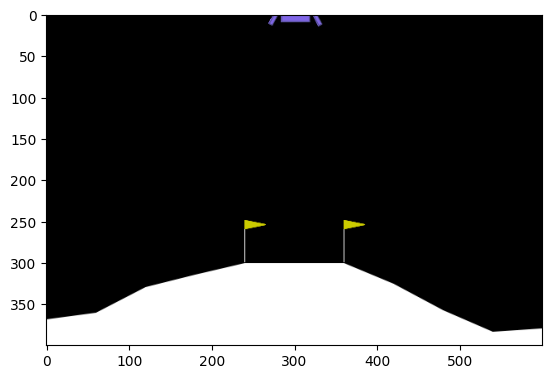

In [125]:
fig, ax = plt.subplots()
ani = FuncAnimation(fig,lambda i: ax.imshow(frames[::10][i]),frames=len(frames[::10]))

In [126]:
# !conda install -c conda-forge ffmpeg

In [127]:
IPython.display.HTML(ani.to_jshtml())

### Replay Buffer

`-` 랜덤액션을 연속적으로 생성하고 그 결과를 기록해보자.

In [334]:
states = []
actions = []
rewards = []
next_states = []
terminateds = []

In [335]:
_state1, _ = env.reset()
for t in range(1500):
    _action = env.action_space.sample() 
    _state2, _reward, _terminated, _truncated, _info = env.step(_action)
    ## save code 
    states.append(_state1) 
    actions.append(_action)
    rewards.append(_reward)
    next_states.append(_state2)
    terminateds.append(_terminated)
    ## save code end 
    _state1 = _state2 
    if _terminated:
        break

In [336]:
env.reset()

In [337]:
env.step(_action)

`-` 모인 히스토리를 확인해보자.

In [338]:
len(states), len(actions), len(next_states), len(rewards), len(terminateds)

### Qnetwork 설계

`-` 네트워크의 목적: 내가 여기서 뭘 해야하는지 알려줘! = 내가 이
상태에서, 어떠한 액션을 해야하는지 알려줘 $\to$ 8개의 상태를 입력으로
받으면 4개의 액션에 대한 좋은 정도를 숫자로 표현하는 어떠한 함수를
만들자.

`-` net 설계

In [339]:
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=8, out_features=128),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=128, out_features=64),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=64, out_features=32),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=32, out_features=4)
)
net

In [340]:
net(torch.tensor(states))

### Policy 설계

`-` 네트워크의 의미

In [341]:
states[0],states[1]

In [342]:
net(torch.tensor(states[0:2]))

-   상태0에서는 액션0이, 상태1에서도 액션0이 가장 좋다는 의미 (왜?
    q-value가 젤 높으니까..)

`-` 따라서 Agent는 아래와 같이 행동해야 한다. (네트워크가 잘
학습되었다는 전제가 필요함) - state\[0\] -\> action = 0 - state\[1\] -\>
action = 0

In [343]:
net(torch.tensor(states[0:2])).max(axis=1)

In [344]:
net(torch.tensor(states[0:2])).max(axis=1)[1]

`-` 네트워크가 있으므로 이제 어떠한 state에 대해서도 뭘 해야할지 (=어떤
액션을 해야할지) 알 수 있다.

In [347]:
_state1 # 어떤 state에 대해서도.. 

In [348]:
int(torch.argmax(net(torch.tensor(_state1)))) # 그래서 다음에 우리가 어떤행동을 해야할 지 알 수 있음

### 학습

`-` 네트워크를 학습시키자.

In [353]:
net

In [379]:
scores=[]
playtimes=[] 
eps = 0
opt = torch.optim.Adam(net.parameters(),lr=0.01)

In [380]:
for epsd in range(1,2001): # 게임 2000판 시켜줌.. 
    state1,_  = env.reset() # 환경리셋 + 초기화된 환경을 state라는 변수에 저장 
    score = 0 
    for t in range(1000): # 게임1판당 max 1000프레임만 할 수 있음
        action = int(torch.argmax(net(torch.tensor(state1)))) # 네트워크가 알려주는 action을 뽑음 
        
        # (step2) Agent -> Env // Env -> Agent 
        state2, reward, terminated, truncated, info = env.step(action) # 액션을 환경에 전달 -> (next_state, reward, done) 을 받음 
        
        # (step3) Agnet: save data and learn 
        ## save data 
        states.append(state1)
        actions.append(action)
        rewards.append(reward)
        next_states.append(state2)
        terminateds.append(terminated)
    
        ## 최근 500개의 자료만 준비함. 
        if len(states)>500:
            _states = torch.tensor(states[-500:])
            _actions = torch.tensor(actions[-500:]).reshape(-1,1)
            _next_states = torch.tensor(next_states[-500:])
            _rewards = torch.tensor(rewards[-500:]).reshape(-1,1)
            _terminateds = torch.tensor(terminateds[-500:]).to(torch.float).reshape(-1,1) 
        else:
            _states = torch.tensor(states)
            _actions = torch.tensor(actions).reshape(-1,1)
            _next_states = torch.tensor(next_states)
            _rewards = torch.tensor(rewards).reshape(-1,1)
            _terminateds = torch.tensor(terminateds).to(torch.float).reshape(-1,1)

        ## 최근 50000개의 자료에서 8개를 임의로 추출함. 
        _n = len(_states)
        _index = np.random.choice(_n,64) # 128 is batch_size 
        _states = _states[_index]
        _actions = _actions[_index]
        _next_states = _next_states[_index]
        _rewards = _rewards[_index]
        _terminateds = _terminateds[_index]
        
        ## leanrn with pytorch 
        yhat = net(_states).gather(1,_actions).squeeze() ## (s,a) -> q(s,a) // 내가 현재상태 state에서, 현재 action을 하여 얻을 것이라 예상하는 보상 (net가 알려주는) 
        y = _rewards.squeeze() #+ 0.99 * net(_next_states).detach().max(1)[0] * (1-_terminateds.squeeze()) ## 그런데 실제로는 이게 맞다고 봐야지~ 
        loss = torch.mean((y-yhat)**2)
        loss.backward()
        opt.step()
        opt.zero_grad()

        # (step4) Agent: prepare next steps 
        state1 = state2  
        #eps = max(0.05, 0.99*eps) 
        score = score + reward
        
        # terminate 
        if terminated:
            scores.append(score)
            playtimes.append(t)
            break
            
    print('\rEpisode {}\tScore: {:.2f}\tPlaytime: {:.2f}'.format(epsd, scores[-1],playtimes[-1]), end="")
    if epsd % 100 == 0:
        print('\rEpisode {}\tScore: {:.2f}\tPlaytime: {:.2f}'.format(epsd, np.mean(scores[-100:]),np.mean(playtimes[-100])))

Episode 100 Score: -387.24  Playtime: 80.000
Episode 200 Score: -290.72  Playtime: 61.000
Episode 300 Score: -290.32  Playtime: 82.0000
Episode 400 Score: -321.50  Playtime: 158.00
Episode 500 Score: -345.35  Playtime: 78.0000
Episode 600 Score: -347.79  Playtime: 56.0000
Episode 700 Score: -187.64  Playtime: 61.000
Episode 800 Score: -206.72  Playtime: 51.000
Episode 900 Score: -242.74  Playtime: 82.0000
Episode 1000    Score: -270.24  Playtime: 172.00
Episode 1100    Score: -239.00  Playtime: 88.0000
Episode 1200    Score: -256.10  Playtime: 136.00
Episode 1300    Score: -261.52  Playtime: 77.000
Episode 1400    Score: -310.77  Playtime: 110.00
Episode 1500    Score: -443.30  Playtime: 99.0000
Episode 1600    Score: -553.26  Playtime: 68.0000
Episode 1700    Score: -571.14  Playtime: 51.000
Episode 1800    Score: -592.59  Playtime: 82.0000
Episode 1900    Score: -606.76  Playtime: 66.0000
Episode 2000    Score: -679.92  Playtime: 83.0000

In [ ]:
# for epsd in range(1,2001): # 게임 2000판 시켜줌.. 
#     state1,_  = env.reset() # 환경리셋 + 초기화된 환경을 state라는 변수에 저장 
#     score = 0 
#     for t in range(1000): # 게임1판당 max 1000프레임만 할 수 있음
#         # (step1) Agent: action 
#         if np.random.rand() < eps: 
#             action = env.action_space.sample() # 랜덤액션을 뽑음 
#         else:
#             action = int(torch.argmax(net(torch.tensor(state1).to("cuda:0")))) # 네트워크가 알려주는 action을 뽑음 
        
#         # (step2) Agent -> Env // Env -> Agent 
#         state2, reward, terminated, truncated, info = env.step(action) # 액션을 환경에 전달 -> (next_state, reward, done) 을 받음 
        
#         # (step3) Agnet: save data and learn 
#         ## save data 
#         states.append(state1)
#         actions.append(action)
#         rewards.append(reward)
#         next_states.append(state2)
#         terminateds.append(terminated)
    
#         ## 최근 50000개의 자료만 준비함. 
#         if len(states)>50000:
#             _states = torch.tensor(states[-50000:])
#             _actions = torch.tensor(actions[-50000:]).reshape(-1,1)
#             _next_states = torch.tensor(next_states[-50000:])
#             _rewards = torch.tensor(rewards[-50000:]).reshape(-1,1)
#             _terminateds = torch.tensor(terminateds[-50000:]).to(torch.float).reshape(-1,1) 
#         else:
#             _states = torch.tensor(states)
#             _actions = torch.tensor(actions).reshape(-1,1)
#             _next_states = torch.tensor(next_states)
#             _rewards = torch.tensor(rewards).reshape(-1,1)
#             _terminateds = torch.tensor(terminateds).to(torch.float).reshape(-1,1)

#         ## 최근 50000개의 자료에서 128개를 임의로 추출함. 
#         _n = len(_states)
#         _index = np.random.choice(_n,128) # 128 is batch_size 
#         _states = _states[_index]
#         _actions = _actions[_index]
#         _next_states = _next_states[_index]
#         _rewards = _rewards[_index]
#         _terminateds = _terminateds[_index]
        
#         ## GPU로 이동 
#         _states = _states.to("cuda:0")
#         _actions = _actions.to("cuda:0")
#         _next_states = _next_states.to("cuda:0")
#         _rewards = _rewards.to("cuda:0")
#         _terminateds = _terminateds.to("cuda:0")
        
#         ## leanrn with pytorch 
#         yhat = net(_states).gather(1,_actions) ## (s,a) -> q(s,a) // 내가 현재상태 state에서, 현재 action을 하여 얻을 것이라 예상하는 보상 (net가 알려주는) 
#         y = _rewards + 0.99 * net(_next_states).detach().max(1)[0].reshape(-1,1)*(1-_terminateds) ## 그런데 실제로는 이게 맞다고 봐야지~ 
#         loss = torch.mean((y-yhat)**2)
#         loss.backward()
        
#         opt.step()
#         opt.zero_grad()

#         # (step4) Agent: prepare next steps 
#         state1 = state2  
#         eps = max(0.05, 0.99*eps) 
#         score = score + reward
        
#         # terminate 
#         if terminated:
#             scores.append(score)
#             playtimes.append(t)
#             break
            
#     print('\rEpisode {}\tScore: {:.2f}\tPlaytime: {:.2f}'.format(epsd, scores[-1],playtimes[-1]), end="")
#     if epsd % 100 == 0:
#         print('\rEpisode {}\tScore: {:.2f}\tPlaytime: {:.2f}'.format(epsd, np.mean(scores[-100:]),np.mean(playtimes[-100])))